In [1]:
import squigglepy as sq
import numpy as np
import pandas as pd
from squigglepy.numbers import K, M, B
from chip_estimates_utils import (
    normalize_shares,
    summarize_quarterly_by_chip,
    summarize_calendar_quarters,
    print_cumulative_summary,
    estimate_chip_sales,
    interpolate_to_calendar_quarters,
)

sq.set_seed(42)
np.random.seed(42)
N_SAMPLES = 5000
H100_TOPS = 1979

Spreadsheet with input data for quarterly revenue and GPU prices: https://docs.google.com/spreadsheets/d/1RfjL98gsSe9QeXDnBOraticvS-s13XmKvHv_dwwa3W8/

In [2]:
SPREADSHEET_ID = "1RfjL98gsSe9QeXDnBOraticvS-s13XmKvHv_dwwa3W8"

# Sheet GIDs
REVENUE_GID = 0
PROD_MIX_GID = 141507805

REVENUE_URL = f"https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}/gviz/tq?tqx=out:csv&gid={REVENUE_GID}"
PROD_MIX_URL = f"https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}/gviz/tq?tqx=out:csv&gid={PROD_MIX_GID}"

In [3]:
# Load data from sheets into dataframes
revenue_df = pd.read_csv(REVENUE_URL)

revenue_df = revenue_df[['quarter', 'instinct_revenue_p5', 'instinct_revenue_p95']].dropna()
print(f"Loaded {len(revenue_df)} quarters of revenue data")
print(revenue_df)

prod_mix_df = pd.read_csv(PROD_MIX_URL)

prod_mix_df = prod_mix_df[['quarter', 'chip_type', 'share_p5', 'share_p95']].dropna()
print(f"Loaded {len(prod_mix_df)} version-quarter combinations")
print(prod_mix_df)

Loaded 7 quarters of revenue data
   quarter  instinct_revenue_p5  instinct_revenue_p95
0  FY24 Q1                  0.6                  0.90
1  FY24 Q2                  1.0                  1.25
2  FY24 Q3                  1.4                  1.60
3  FY24 Q4                  1.7                  1.90
4  FY25 Q1                  1.3                  1.80
5  FY25 Q2                  0.8                  1.30
6  FY25 Q3                  1.7                  2.40
Loaded 22 version-quarter combinations
    quarter chip_type  share_p5  share_p95
0   FY24 Q1    MI300A      0.01       0.05
1   FY24 Q1    MI250X      0.25       0.50
2   FY24 Q1    MI300X      0.45       0.60
3   FY24 Q2    MI300X      0.75       0.90
4   FY24 Q2    MI300A      0.02       0.10
5   FY24 Q2    MI250X      0.01       0.10
6   FY24 Q3    MI300X      0.70       0.90
7   FY24 Q3    MI300A      0.15       0.25
8   FY24 Q3    MI250X      0.01       0.05
9   FY24 Q4    MI300X      0.75       0.85
10  FY24 Q4    MI300A 

In [4]:
# ==============================================
# Convert input data to squigglepy distributions
# ==============================================

# Convert revenue DataFrame to dictionary of distributions (revenue in billions)
AMD_REVENUE = {}
for _, row in revenue_df.iterrows():
    quarter = row['quarter']
    # Revenue values are in billions
    AMD_REVENUE[quarter] = sq.norm(row['instinct_revenue_p5'] * B, row['instinct_revenue_p95'] * B)

for quarter in AMD_REVENUE.keys():
    print(quarter, AMD_REVENUE[quarter])

# Convert production mix DataFrame to nested dictionary of distributions
PROD_MIX = {}
for quarter in prod_mix_df['quarter'].unique():
    quarter_data = prod_mix_df[prod_mix_df['quarter'] == quarter]
    PROD_MIX[quarter] = {}
    for _, row in quarter_data.iterrows():
        chip_type = row['chip_type']
        PROD_MIX[quarter][chip_type] = sq.norm(row['share_p5'], row['share_p95'], lclip=0, rclip=1)

for quarter in PROD_MIX.keys():
    print(quarter, PROD_MIX[quarter])

FY24 Q1 <Distribution> norm(mean=750000000.0, sd=91193524.79)
FY24 Q2 <Distribution> norm(mean=1125000000.0, sd=75994603.99)
FY24 Q3 <Distribution> norm(mean=1500000000.0, sd=60795683.19)
FY24 Q4 <Distribution> norm(mean=1800000000.0, sd=60795683.19)
FY25 Q1 <Distribution> norm(mean=1550000000.0, sd=151989207.98)
FY25 Q2 <Distribution> norm(mean=1050000000.0, sd=151989207.98)
FY25 Q3 <Distribution> norm(mean=2050000000.0, sd=212784891.17)
FY24 Q1 {'MI300A': <Distribution> norm(mean=0.03, sd=0.01, lclip=0, rclip=1) (version 0.29), 'MI250X': <Distribution> norm(mean=0.38, sd=0.08, lclip=0, rclip=1) (version 0.29), 'MI300X': <Distribution> norm(mean=0.53, sd=0.05, lclip=0, rclip=1) (version 0.29)}
FY24 Q2 {'MI300X': <Distribution> norm(mean=0.82, sd=0.05, lclip=0, rclip=1) (version 0.29), 'MI300A': <Distribution> norm(mean=0.06, sd=0.02, lclip=0, rclip=1) (version 0.29), 'MI250X': <Distribution> norm(mean=0.06, sd=0.03, lclip=0, rclip=1) (version 0.29)}
FY24 Q3 {'MI300X': <Distribution> n

In [5]:
# ==============================================
# AMD INSTINCT SPECS AND PRICES
# ==============================================

# AMD Instinct specs: 8-bit TOPS
AMD_SPECS = {
    'MI250X': {'tops': 383},
    'MI300X': {'tops': 2615},
    'MI300A': {'tops': 1961},
    'MI325X': {'tops': 2615},
    'MI350X': {'tops': 4614},
    'MI355X': {'tops': 5033},
}

# Average Selling Prices (ASP)
AMD_PRICES = {
    # MI300X: Price between $10k and $15k... MSFT pays roughly $10k
    'MI300X': sq.to(10000, 15000),
    # MI300A: El Capitan was 44.5K MI300A and we estimate that cost $300M in compute which comes out to $6.7k per GPU
    'MI300A': sq.to(6000, 7500),
    # MI325X: $10K - $20K
    'MI325X': sq.to(10000, 20000),
    # Legacy / Other (MI250X): $8k - 12k
    'MI250X': sq.to(8000, 12000),
    # MI350X: $22k - $25k. lower end of $22k assuming bulk discount
    'MI350X': sq.to(22000, 25000),
    # MI355X
    'MI355X': sq.to(25000, 30000),
}

In [6]:
# ==============================================
# SAMPLING FUNCTIONS
# ==============================================

def sample_revenue(quarter):
    return (AMD_REVENUE[quarter] @ 1)

def sample_shares(quarter):
    # sample one revenue mix, then normalize
    mix = PROD_MIX[quarter]
    raw_shares = {chip_type: dist @ 1 for chip_type, dist in mix.items()}
    return normalize_shares(raw_shares)

def sample_price(quarter, chip_type):
    return AMD_PRICES[chip_type] @ 1

In [7]:
# ==============================================
# RUN MONTE CARLO SIMULATION
# ==============================================

sim_results = estimate_chip_sales(
    quarters=list(AMD_REVENUE.keys()),
    versions=list(AMD_SPECS.keys()),
    sample_revenue=sample_revenue,
    sample_shares=sample_shares,
    sample_price=sample_price,
    n_samples=N_SAMPLES
)

In [8]:
# Detailed summary with each chip type as separate columns with 90% CI
summary_df = summarize_quarterly_by_chip(sim_results)
print("AMD Volumes by Quarter (median with 90% CI)")
print(summary_df.to_string(index=False))

AMD Volumes by Quarter (median with 90% CI)
Quarter        MI250X          MI300X        MI300A        MI325X        MI350X       MI355X            Total
FY24 Q1 30k (20k-42k)   34k (25k-47k)    4k (1k-6k)             -             -            -    69k (53k-87k)
FY24 Q2   7k (1k-12k)  81k (63k-103k)  10k (4k-18k)             -             -            -   98k (80k-120k)
FY24 Q3    4k (2k-8k)  94k (75k-119k) 44k (33k-56k)             -             -            - 143k (122k-168k)
FY24 Q4    4k (2k-6k) 115k (93k-143k) 52k (40k-66k)             -             -            - 172k (147k-200k)
FY25 Q1             -  85k (63k-114k)    5k (2k-7k) 33k (20k-52k)             -            -  124k (97k-156k)
FY25 Q2             -   46k (31k-65k)             - 27k (16k-44k)    4k (2k-7k)            -   78k (57k-104k)
FY25 Q3             -   46k (28k-67k)             -  20k (8k-36k) 36k (27k-47k) 12k (8k-17k)  116k (92k-142k)


In [9]:
# ==============================================
# CUMULATIVE TOTALS BY CHIP TYPE
# ==============================================
# Note: don't trust the confidence intervals here, because they don't account 
# for correlation across quarters. This means they are probably too narrow.

cumulative = {chip_type: np.zeros(N_SAMPLES) for chip_type in AMD_SPECS}
for quarter in sim_results:
    for chip_type in AMD_SPECS:
        cumulative[chip_type] += np.array(sim_results[quarter][chip_type])

print_cumulative_summary(cumulative, AMD_SPECS, "Cumulative AMD Instinct Production (Q1 2024 - Q3 2025)")


Cumulative AMD Instinct Production (Q1 2024 - Q3 2025)
Version           p5          p50          p95
---------------------------------------------
MI250X       33,277       45,349       58,991
MI300X      455,500      507,252      564,168
MI300A       96,889      115,263      134,145
MI325X       59,087       80,902      109,576
MI350X       30,857       40,526       51,950
MI355X        7,954       12,387       17,491
---------------------------------------------
TOTAL       743,025      803,667      869,198


In [ ]:
# ==============================================
# EXPORT TO CSV
# ==============================================

from datetime import datetime
import matplotlib.pyplot as plt

# AMD uses calendar quarters, FY24 = calendar 2024
def get_quarter_dates(quarter_str):
    """Convert quarter string like 'FY24 Q1' to start and end dates."""
    parts = quarter_str.split()
    fy = int(parts[0][2:])  # FY24 -> 24
    q_num = int(parts[1][1])  # Q1 -> 1
    year = 2000 + fy  # 24 -> 2024
    
    quarter_dates = {
        1: (f"{year}-01-01", f"{year}-03-31"),
        2: (f"{year}-04-01", f"{year}-06-30"),
        3: (f"{year}-07-01", f"{year}-09-30"),
        4: (f"{year}-10-01", f"{year}-12-31"),
    }
    return quarter_dates[q_num]

# Get current timestamp for notes
timestamp = datetime.now().strftime("%m-%d-%Y %H:%M")
generated_note = f"Estimates generated on: {timestamp}"

# Create rows for output
rows = []

for quarter in sim_results:
    start_date, end_date = get_quarter_dates(quarter)
    
    for chip_type in AMD_SPECS:
        arr = np.array(sim_results[quarter][chip_type])
        if arr.sum() > 0:
            # Calculate H100 equivalents
            h100e_arr = arr * (AMD_SPECS[chip_type]['tops'] / H100_TOPS)
            
            rows.append({
                'Name': f"{quarter} - {chip_type}",
                'Chip manufacturer': 'AMD',
                'Start date': start_date,
                'End date': end_date,
                'Compute estimate in H100e (median)': int(np.percentile(h100e_arr, 50)),
                'H100e (5th percentile)': int(np.percentile(h100e_arr, 5)),
                'H100e (95th percentile)': int(np.percentile(h100e_arr, 95)),
                'Number of Units': int(np.percentile(arr, 50)),
                'Number of Units (5th percentile)': int(np.percentile(arr, 5)),
                'Number of Units (95th percentile)': int(np.percentile(arr, 95)),
                'Source / Link': '',
                'Notes': generated_note,
                'Chip type': chip_type,
                'Last Modified By': '',
                'Last Modified': '',
            })

# Create output dataframe
amd_timelines = pd.DataFrame(rows)

# Save to CSV
output_path = 'amd_chip_timelines.csv'
amd_timelines.to_csv(output_path, index=False)

print(f"Exported to {output_path}")
print(f"\n{len(rows)} rows exported")
print(amd_timelines[['Name', 'Chip manufacturer', 'Start date', 'End date', 
                      'Compute estimate in H100e (median)', 'Number of Units', 'Chip type']].to_string())

Exported to amd_chip_timelines.csv

22 rows exported
                Name Chip manufacturer  Start date    End date  Compute estimate in H100e (median)  Number of Units Chip type
0   FY24 Q1 - MI250X               AMD  2024-01-01  2024-03-31                                5877            30367    MI250X
1   FY24 Q1 - MI300X               AMD  2024-01-01  2024-03-31                               45514            34445    MI300X
2   FY24 Q1 - MI300A               AMD  2024-01-01  2024-03-31                                3505             3537    MI300A
3   FY24 Q2 - MI250X               AMD  2024-04-01  2024-06-30                                1286             6645    MI250X
4   FY24 Q2 - MI300X               AMD  2024-04-01  2024-06-30                              106636            80701    MI300X
5   FY24 Q2 - MI300A               AMD  2024-04-01  2024-06-30                               10395            10490    MI300A
6   FY24 Q3 - MI250X               AMD  2024-07-01  2024-09-30   

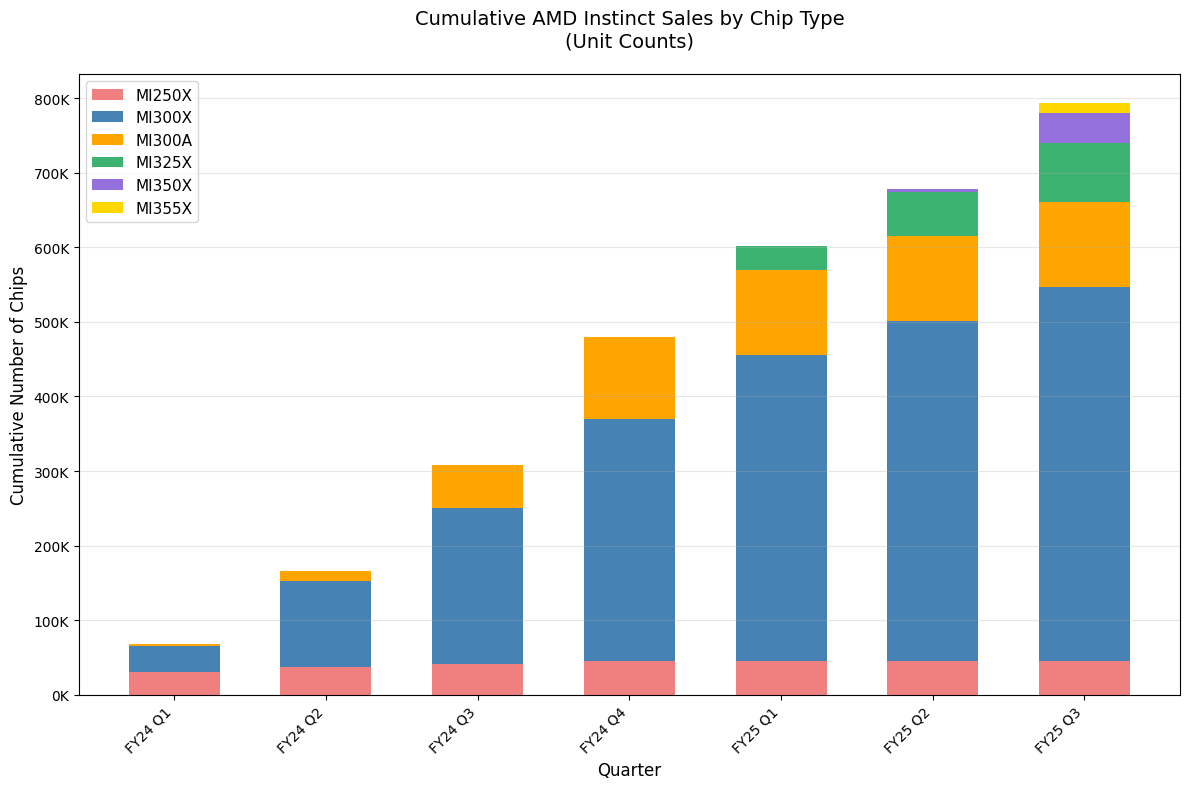

In [11]:
# ==============================================
# VISUALIZATION: CUMULATIVE SALES BY CHIP TYPE (UNIT COUNTS)
# ==============================================

# Colors for each AMD chip type
AMD_COLORS = {
    'MI250X': 'lightcoral',
    'MI300X': 'steelblue',
    'MI300A': 'orange',
    'MI325X': 'mediumseagreen',
    'MI350X': 'mediumpurple',
    'MI355X': 'gold',
}

# Get quarters in order
quarters = list(sim_results.keys())
chip_types = list(AMD_SPECS.keys())

# Calculate median quantities for each chip type by quarter
chip_data = {chip: [] for chip in chip_types}
for quarter in quarters:
    for chip in chip_types:
        arr = np.array(sim_results[quarter][chip])
        chip_data[chip].append(int(np.percentile(arr, 50)))

# --- PLOT 1: Cumulative Unit counts ---
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

# Calculate cumulative sums for each chip type
chip_data_cumulative = {chip: np.cumsum(chip_data[chip]) for chip in chip_types}

bottom = np.zeros(len(quarters))
for chip in chip_types:
    values = chip_data_cumulative[chip]
    if values.sum() > 0:
        ax.bar(x, values, width, label=chip, bottom=bottom, color=AMD_COLORS[chip])
        bottom += values

ax.set_ylabel('Cumulative Number of Chips', fontsize=12)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Cumulative AMD Instinct Sales by Chip Type\n(Unit Counts)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(quarters, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=11, loc='upper left')

plt.tight_layout()
plt.savefig("visualizations/amd_cumulative_sales_units.png", dpi=300, bbox_inches="tight")
plt.show()

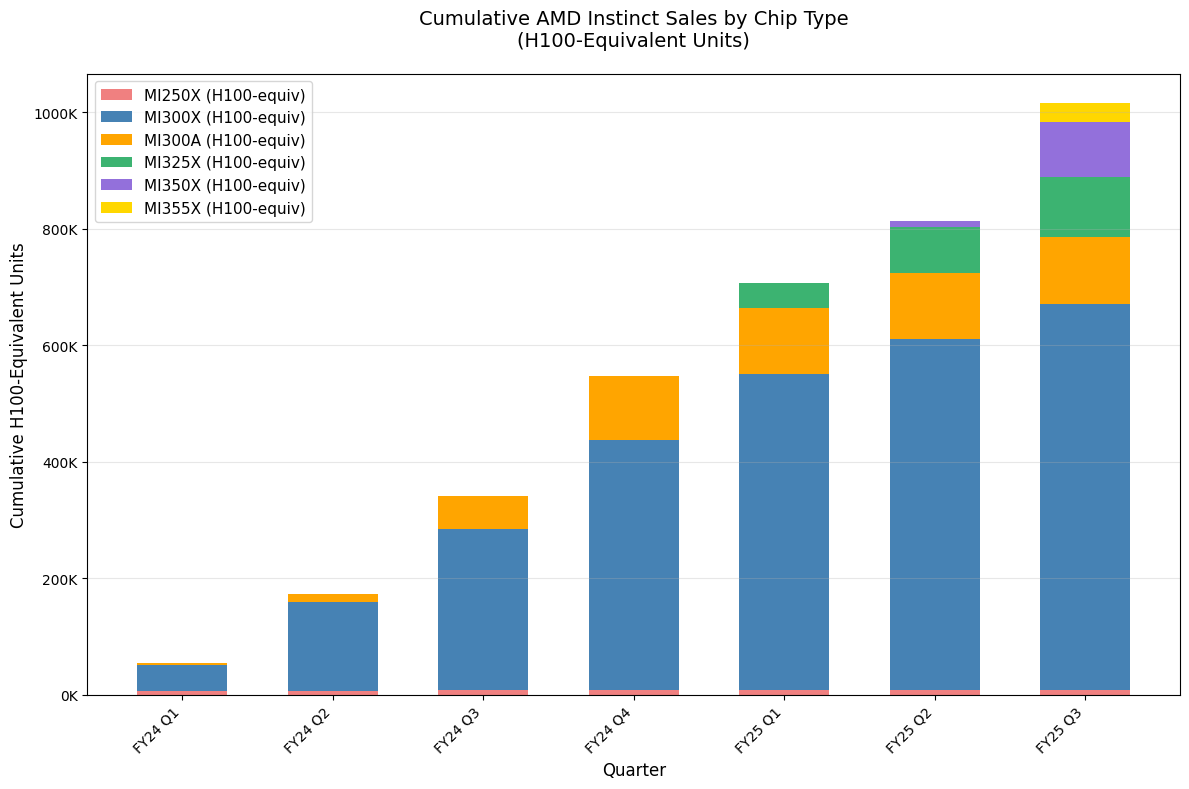

In [12]:
# ==============================================
# VISUALIZATION: CUMULATIVE SALES IN H100-EQUIVALENTS
# ==============================================

# Calculate H100-equivalent quantities for each chip type by quarter
chip_data_h100e = {chip: [] for chip in chip_types}
for quarter in quarters:
    for chip in chip_types:
        arr = np.array(sim_results[quarter][chip])
        h100e_arr = arr * (AMD_SPECS[chip]['tops'] / H100_TOPS)
        chip_data_h100e[chip].append(int(np.percentile(h100e_arr, 50)))

# --- PLOT 2: Cumulative H100-equivalents ---
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

# Calculate cumulative sums for each chip type
chip_data_h100e_cumulative = {chip: np.cumsum(chip_data_h100e[chip]) for chip in chip_types}

bottom = np.zeros(len(quarters))
for chip in chip_types:
    values = chip_data_h100e_cumulative[chip]
    if values.sum() > 0:
        ax.bar(x, values, width, label=f'{chip} (H100-equiv)', bottom=bottom, color=AMD_COLORS[chip])
        bottom += values

ax.set_ylabel('Cumulative H100-Equivalent Units', fontsize=12)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Cumulative AMD Instinct Sales by Chip Type\n(H100-Equivalent Units)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(quarters, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=11, loc='upper left')

plt.tight_layout()
plt.savefig("visualizations/amd_cumulative_sales_h100e.png", dpi=300, bbox_inches="tight")
plt.show()